Flux and transport into and out of shelf box in CNTDIFF experiments
==

This notebook explores the similarities and differences between the tracer fluxes when Kiso is changed as well as canyon and no canyon cases. It looks at the flux normal to a shelf wall<sup>1</sup>. Flux is understood here as tracer transport (concentration * vol/s). This gives the following units:

$[Flux] = [C]m^3s^{-1} = (mol/l) (m^3/s) = (mol/s)*1000 $

TracFlux = AdvFlux + DiffFlux 

<sup>1</sup> Wall that goes from shelf-break depth to surface and all along the shelf break of a flat shelf. This needs to take into account the vertical component of flux onto the shelf when there is a canyon.

The base case to compare the effect isopycnal diffusivity is a run with NOGMREDI. The vertical diff for tracer 1 is $10^{-5}$ $m^2s^{-1}$ and $10^{-3}$ $m^2s^{-1}$ for tracer 2. An associated no-canyon case allows to isolate the effect of the canyon (CNTDIFF run07 and NOGMREDI run04).  

CNTDIFF runs include the following cases:

| Run   |   $k_{iso}$ ($m^2s^{-1}$)  | Bathymetry |
|:-----:|:--------------------------:|:-----------------------|
|  02   | 10                         |  Barkley-like          |
|  03   | 1                          |  Barkley-like          |
|  04   | 0.1                        |  Barkley-like          |
|  07   | 1                          |  No canyon             |

NOGMREDI runs used to compare results:

| Run   |   $k_{h}$ ($m^2s^{-1}$)  | Bathymetry |
|:-----:|:--------------------------:|:-----------------------|
|  02   | $10^{-5}$                  |  Barkley-like          |
|  04   | $10^{-5}$                  |  No canyon          |

In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

from math import *

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns

In [2]:
lib_path = os.path.abspath('/ocean/kramosmu/Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 

import ShelfBreakTools_MITgcm as sb


In [3]:
# Functions
def vertTracBox(Mask, W,zlim=30,ylim=230):
    mask_expand = np.expand_dims(Mask[zlim,ylim:,:],0)
    mask_expand = mask_expand + np.zeros(W[:,zlim,ylim:,:].shape)

    vert = W[:,zlim,ylim:,:]
    VertTrans= np.sum(np.sum(np.ma.masked_array(vert,mask = mask_expand),axis=1),axis=1)
    return VertTrans


def vTracBox(Mask,V,zlim=30, ylim=230):
    '''MaskC : mask corresponding to '''
    mask_expand2 = np.expand_dims(Mask[:zlim,ylim,:],0)
    mask_expand2 = mask_expand2 + np.zeros(V[:,:zlim,ylim,:].shape)

    VTRACbox= np.sum(np.sum(np.ma.masked_array(V[:,:zlim,ylim,:],mask = mask_expand2),axis=1),axis=1)
    return(VTRACbox)



In [4]:
#Base case, iso =1 , No 3d diff.
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run02/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)
#for dimobj in CanyonGridOut.variables.values():
#    print dimobj
CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run02/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

FluxTR01 = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run02/FluxTR01Glob.nc'
FluxOut1 = Dataset(FluxTR01)

FluxTR03 = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run02/FluxTR03Glob.nc'
FluxOut3 = Dataset(FluxTR03)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run04/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonStateNoC='/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run04/stateGlob.nc'

FluxTR01NoC = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run04/FluxTR01Glob.nc'
FluxTR03NoC = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run04/FluxTR03Glob.nc'

In [5]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

z = CanyonStateOut.variables['Z']
#print(z[10])
Time = CanyonStateOut.variables['T']
#print(Time[:])

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells

yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

dxF = rout.getField(CanyonGrid, 'dxF')
drF = CanyonGridOut.variables['drF']

In [6]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [7]:
VTR = rout.getField(FluxTR01,'ADVyTr01') # 
UTR = rout.getField(FluxTR01,'ADVxTr01') # 
UTRAC,VTRAC = rout.unstagger(UTR, VTR)

VTR = rout.getField(FluxTR01NoC,'ADVyTr01') # 
UTR = rout.getField(FluxTR01NoC,'ADVxTr01') # 
UTRACNoC,VTRACNoC = rout.unstagger(UTR, VTR)

WTRAC = rout.getField(FluxTR01,'ADVrTr01') # 
#WTRACNoC = rout.getField(FluxTR01NoC,'ADVrTr01') # 


In [8]:
# TRACER 1
FluxTR01cnt2 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run02/FluxTR01Glob.nc'

FluxTR01cnt3  = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/FluxTR01Glob.nc'

FluxTR01cnt4  = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run04/FluxTR01Glob.nc'

FluxTR01cnt7  = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/FluxTR01Glob.nc' 


In [9]:
VTR = rout.getField(FluxTR01cnt2,'ADVyTr01') # 
UTR = rout.getField(FluxTR01cnt2,'ADVxTr01') # 

UTRAC02,VTRAC02 = rout.unstagger(UTR, VTR)
WTRAC02 = rout.getField(FluxTR01cnt2,'ADVrTr01') # 

VTR = rout.getField(FluxTR01cnt3,'ADVyTr01') # 
UTR = rout.getField(FluxTR01cnt3,'ADVxTr01') # 

UTRAC03,VTRAC03 = rout.unstagger(UTR, VTR)
WTRAC03 = rout.getField(FluxTR01cnt3,'ADVrTr01') # 

VTR= rout.getField(FluxTR01cnt4,'ADVyTr01') # 
UTR = rout.getField(FluxTR01cnt4,'ADVxTr01') # 

UTRAC04,VTRAC04 = rout.unstagger(UTR, VTR)
WTRAC04 = rout.getField(FluxTR01cnt4,'ADVrTr01') # 

VTR = rout.getField(FluxTR01cnt7,'ADVyTr01') # 
UTR = rout.getField(FluxTR01cnt7,'ADVxTr01') # 

UTRAC07,VTRAC07 = rout.unstagger(UTR, VTR)
#WTRAC07 = rout.getField(FluxTR01cnt7,'ADVrTr01') # 



In [10]:
vertbase = vertTracBox(MaskC,WTRAC,zlim=30,ylim=230)
vert02 = vertTracBox(MaskC,WTRAC02,zlim=30,ylim=230)
vert03 = vertTracBox(MaskC,WTRAC03,zlim=30,ylim=230)
vert04 = vertTracBox(MaskC,WTRAC04,zlim=30,ylim=230)

CSbase = vTracBox(MaskC,VTRAC,zlim=30,ylim=230)
CSbaseNoC = vTracBox(MaskCNoC,VTRACNoC,zlim=30,ylim=230)
CS02 = vTracBox(MaskC,VTRAC02,zlim=30,ylim=230)
CS03 = vTracBox(MaskC,VTRAC03,zlim=30,ylim=230)
CS04 = vTracBox(MaskC,VTRAC04,zlim=30,ylim=230)
CS07 = vTracBox(MaskC,VTRAC07,zlim=30,ylim=230)
   

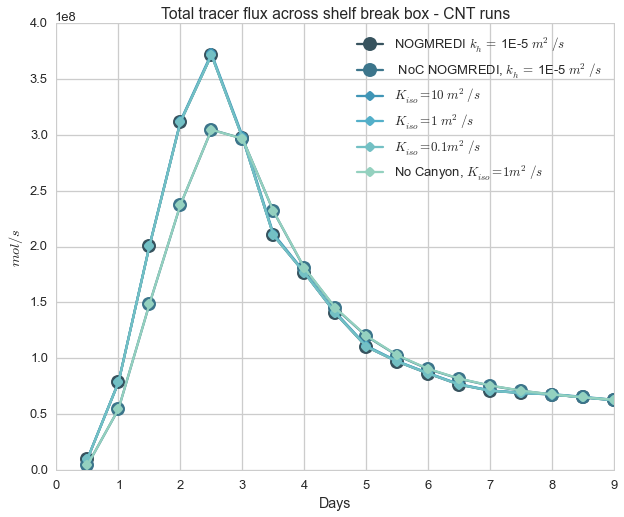

In [43]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol/s$'

with sns.color_palette("GnBu_d", 6):
    fig44 = plt.figure(figsize=figSize)
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    ax.plot(times,(vertbase+CSbase)*1000.0,'o-',markersize = 14,label = 'NOGMREDI $k_h=$ 1E-5 $m^2/s$ ')
    ax.plot(times,CSbaseNoC*1000.0,'o-',markersize = 14,label = ' NoC NOGMREDI, $k_h=$ 1E-5 $m^2/s$ ')
    ax.plot(times,(vert02+CS02)*1000.0,'o-',label = '$K_{iso} = 10$ $m^2/s$')
    ax.plot(times,(vert03+CS03)*1000.0,'o-',label = '$K_{iso} = 1$ $m^2/s$')
    ax.plot(times,(vert04+CS04)*1000.0,'o-',label = '$K_{iso} = 0.1$$m^2/s$')
    ax.plot(times,(CS07)*1000.0,'o-',label = 'No Canyon, $K_{iso} = 1$$m^2/s$')
    
    handles, labels = ax.get_legend_handles_labels()
    display = (0,1,2,3,4,5,6)
    ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
    plt.xlabel('Days')
    plt.ylabel(unitsTr)
    plt.title('Total tracer flux across shelf break box - CNT runs')
    

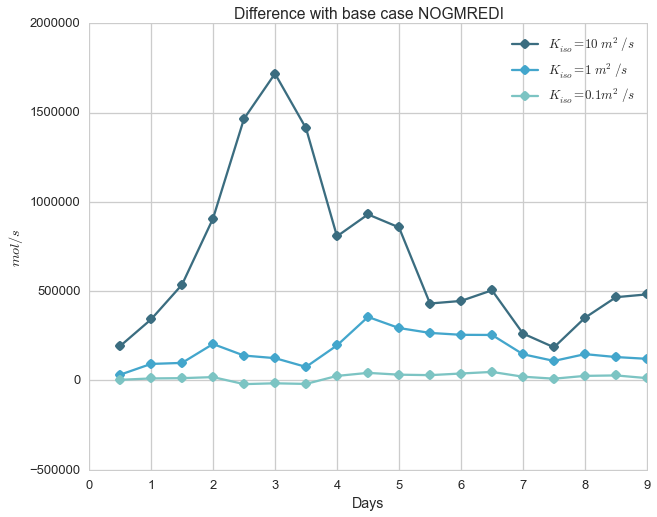

In [20]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol/s$'

with sns.color_palette("GnBu_d", 3):
    fig44 = plt.figure(figsize=figSize)
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    
    ax.plot(times,((vert02+CS02)-(vertbase+CSbase))*1000.0,'o-',label = '$K_{iso} = 10$ $m^2/s$')
    ax.plot(times,((vert03+CS03)-(vertbase+CSbase))*1000.0,'o-',label = '$K_{iso} = 1$ $m^2/s$')
    ax.plot(times,((vert04+CS04)-(vertbase+CSbase))*1000.0,'o-',label = '$K_{iso} = 0.1$$m^2/s$')
    
    handles, labels = ax.get_legend_handles_labels()
    display = (0,1,2,3,4,5)
    ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
    plt.xlabel('Days')
    plt.ylabel(unitsTr)
    plt.title('Difference with base case NOGMREDI')
    

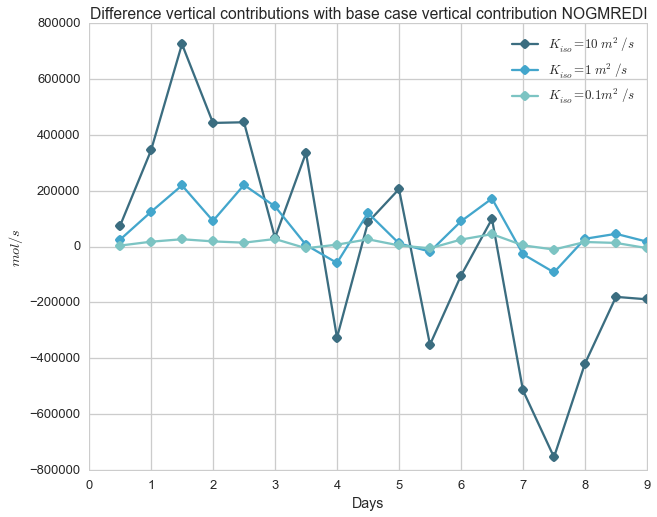

In [46]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol/s$'

with sns.color_palette("GnBu_d", 3):
    fig44 = plt.figure(figsize=figSize)
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    
    ax.plot(times,(vert02-(vertbase))*1000.0,'o-',label = '$K_{iso} = 10$ $m^2/s$')
    ax.plot(times,(vert03-(vertbase))*1000.0,'o-',label = '$K_{iso} = 1$ $m^2/s$')
    ax.plot(times,(vert04-(vertbase))*1000.0,'o-',label = '$K_{iso} = 0.1$$m^2/s$')
    
    handles, labels = ax.get_legend_handles_labels()
    display = (0,1,2,3,4,5)
    ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
    plt.xlabel('Days')
    plt.ylabel(unitsTr)
    plt.title('Difference vertical contributions with base case vertical contribution NOGMREDI')
    

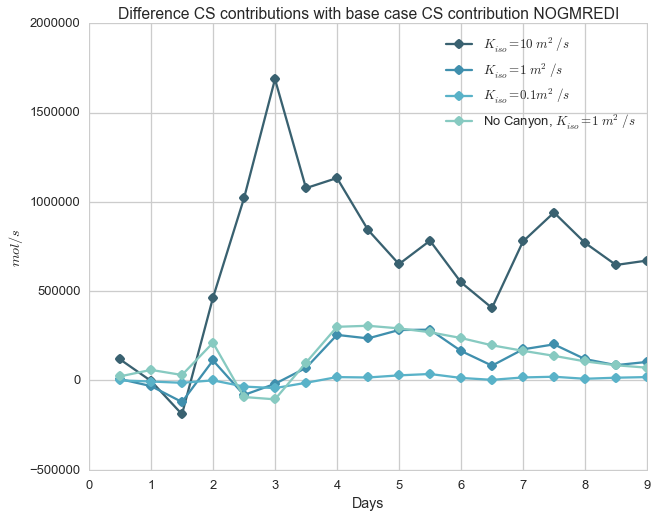

In [48]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol/s$'

with sns.color_palette("GnBu_d", 4):
    fig44 = plt.figure(figsize=figSize)
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    
    ax.plot(times,(CS02-(CSbase))*1000.0,'o-',label = '$K_{iso} = 10$ $m^2/s$')
    ax.plot(times,(CS03-(CSbase))*1000.0,'o-',label = '$K_{iso} = 1$ $m^2/s$')
    ax.plot(times,(CS04-(CSbase))*1000.0,'o-',label = '$K_{iso} = 0.1$$m^2/s$')
    ax.plot(times,(CS07-(CSbaseNoC))*1000.0,'o-',label = 'No Canyon, $K_{iso} = 1$ $m^2/s$')
    
    handles, labels = ax.get_legend_handles_labels()
    display = (0,1,2,3,4,5)
    ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
    plt.xlabel('Days')
    plt.ylabel(unitsTr)
    plt.title('Difference CS contributions with base case CS contribution NOGMREDI')
    

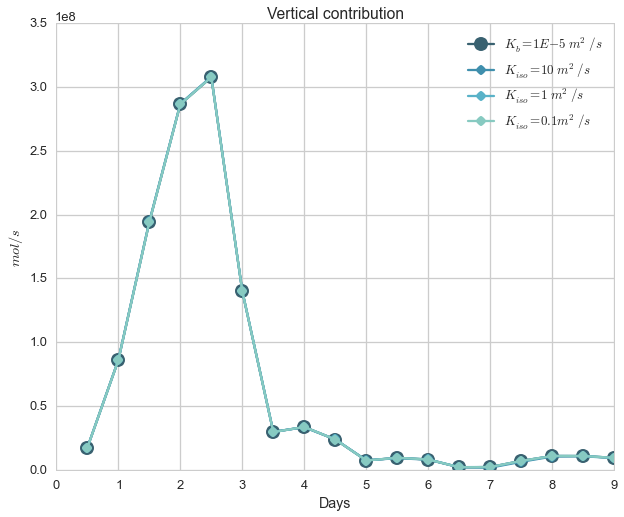

In [42]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol/s$'

with sns.color_palette("GnBu_d", 4):
    fig44 = plt.figure(figsize=figSize)
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    ax.plot(times,(vertbase)*1000.0,'o-',markersize = 14,label = '$K_{b} = 1E-5$ $m^2/s$')
    ax.plot(times,(vert02)*1000.0,'o-',label = '$K_{iso} = 10$ $m^2/s$')
    ax.plot(times,(vert03)*1000.0,'o-',label = '$K_{iso} = 1$ $m^2/s$')
    ax.plot(times,(vert04)*1000.0,'o-',label = '$K_{iso} = 0.1$$m^2/s$')
    
    handles, labels = ax.get_legend_handles_labels()
    display = (0,1,2,3,4,5)
    ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
    plt.xlabel('Days')
    plt.ylabel(unitsTr)
    plt.title('Vertical contribution')
    

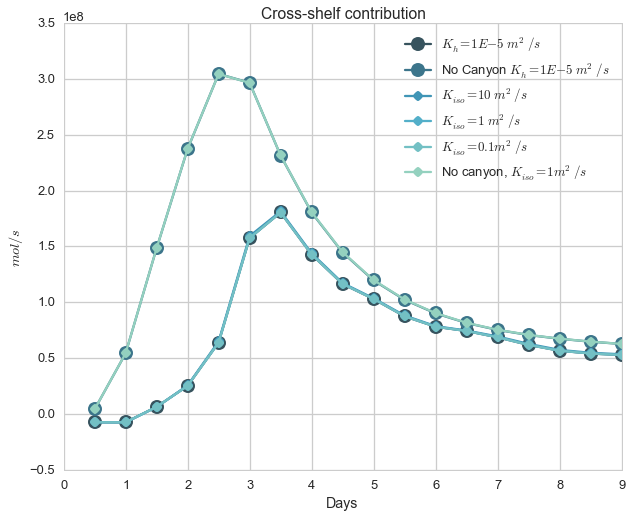

In [41]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol/s$'

with sns.color_palette("GnBu_d", 6):
    fig44 = plt.figure(figsize=figSize)
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    ax.plot(times,(CSbase)*1000.0,'o-',markersize = 14,label = '$K_{h} = 1E-5$ $m^2/s$')
    ax.plot(times,(CSbaseNoC)*1000.0,'o-',markersize = 14,label = 'No Canyon $K_{h} = 1E-5$ $m^2/s$')
    ax.plot(times,(CS02)*1000.0,'o-',label = '$K_{iso} = 10$ $m^2/s$')
    ax.plot(times,(CS03)*1000.0,'o-',label = '$K_{iso} = 1$ $m^2/s$')
    ax.plot(times,(CS04)*1000.0,'o-',label = '$K_{iso} = 0.1$$m^2/s$')
    ax.plot(times,(CS07)*1000.0,'o-',label = 'No canyon, $K_{iso} = 1$$m^2/s$')
    
    handles, labels = ax.get_legend_handles_labels()
    display = (0,1,2,3,4,5)
    ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
    plt.xlabel('Days')
    plt.ylabel(unitsTr)
    plt.title('Cross-shelf contribution')
    

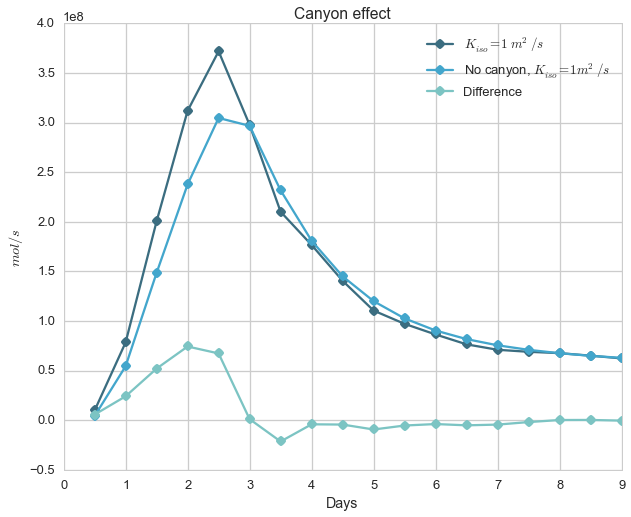

In [44]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol/s$'

with sns.color_palette("GnBu_d", 3):
    fig44 = plt.figure(figsize=figSize)
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    ax.plot(times,(vert03+CS03)*1000.0,'o-',label = '$K_{iso} = 1$ $m^2/s$')
    ax.plot(times,(CS07)*1000.0,'o-',label = 'No canyon, $K_{iso} = 1$$m^2/s$')
    ax.plot(times,(vert03+CS03-CS07)*1000.0,'o-',label = 'Difference')
    
    handles, labels = ax.get_legend_handles_labels()
    display = (0,1,2,3,4,5)
    ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
    plt.xlabel('Days')
    plt.ylabel(unitsTr)
    plt.title('Canyon effect')
    